# Backstory

## ***For this problem, each user we will try to find out:***

### Where are they come from.
### What is the most like topic(subreddit) base on sentiment
### What is the most dislike topic(subreddit) base on sentiment
### Their active level (number of comments each month)

In [12]:
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, DoubleType, ArrayType, DateType
import string
import re
import math

### Get sample data

In [ ]:
%%time
df = spark.read.format('json').load('hdfs://orion11:11001/reddit/*/*')
print(df.count())

In [ ]:
sampleDF = df.sample(False, 0.1)
sampleDF.write.format('json').save('hdfs://orion11:11001/sampled_reddit')

In [14]:
%%time
sampleDF = sqlContext.read.json("hdfs://orion11:11001/sampled_reddit/*")
# sampleDF.cache()
# print(sampleDF.count())

CPU times: user 21.8 ms, sys: 15.8 ms, total: 37.6 ms
Wall time: 3min 25s


In [ ]:
sampleDFv2 = sampleDF.sample(False, 0.1)
sampleDFv2.write.format('json').save('hdfs://orion11:11001/sampled_reddit_v2')

In [ ]:
%%time
sampleDFv2 = spark.read.format('json').load('hdfs://orion11:11001/sampled_reddit_v2/*')
sampleDFv2.cache()
print(sampleDFv2.count())

In [ ]:
sampleDFv3 = sampleDFv2.sample(False, 0.1)
sampleDFv3.write.format('json').save('hdfs://orion11:11001/sampled_reddit_v3')

In [1]:
%%time
sampleDFv3 = spark.read.format('json').load('hdfs://orion11:11001/sampled_reddit_v3/*')
sampleDFv3.cache()
print(sampleDFv3.count())

3090865
CPU times: user 6.81 ms, sys: 2.84 ms, total: 9.65 ms
Wall time: 15.3 s


### Filter all comment generate by bot/ comment that is delete

In [16]:
%%time
botExpr = "[bB][oO][tT]"

filteredComment = (sampleDF
                   .filter(~(sampleDF.body.like("[deleted]") 
                             | sampleDF.body.like('[removed]') 
                             | sampleDF.author.rlike(botExpr) 
                             | sampleDF.author.like("[deleted]")
                             | sampleDF.author.like("AutoModerator")
                            )
                          )
                   .withColumn("year", func.year(func.from_unixtime("created_utc").cast(DateType())))
                   .withColumn("month", func.month(func.from_unixtime("created_utc").cast(DateType())))
                  )
# sampleDF.unpersist()
filteredComment.cache()
# print(filteredComment.count())

CPU times: user 5.18 ms, sys: 1.31 ms, total: 6.49 ms
Wall time: 77.5 ms


DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, mod_reports: array<string>, name: string, parent_id: string, removal_reason: string, replies: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>, year: int, month: int]

### Look up for comment that might contain the Countries name
To guess that if the comment may contain the countries, we will check if the comment contain the substring __*m from*__ or __*come from*__ for example:   
* "I'm from Vietnam"  
* "I come from Turkey"  
Then we will check the word next to the keyword to see if it is the country name by using __pycountry__ library. If it is a country, we will add to the set to make sure that we will not generate duplicate for that user.  
After that, we only select the user that introduce about their contry and keep it in dataframe to use later.

In [18]:
import re
import pycountry

def preProcessBody(text):
    # lowercase
    text=text.lower()
    
    # remove special characters and digits
#     text=re.sub("(\\d|[^\\w|\\s]|(\_))+","",text)
#     text=re.sub("(\\s)+"," ",text)
    text=re.sub("[^A-Za-z]+"," ",text)
    return text.strip()

def getCountryKeyWord(text):
    text = preProcessBody(text)
    pattern = re.compile('(m from)|(come from)')
#     s = "I'm from Belgium I'll insult that farce for a sport as many names as I damn well please. I'm from Vietnam"
    # l = re.compile("(?<!^)\s+(?=[A-Z])(?!.\s)").split(s)
    subString = pattern.split(text)
    subString = list(filter(None, subString))
#     print(subString)
    numSubString = len(subString)
    result = set([])
    for i in range(numSubString-1):
#         print(subString[i+1])
        if pattern.match(subString[i]):
            words = subString[i+1].split()
            if len(words)>0:
                firstWord = subString[i+1].split()[0]
                name = pycountry.countries.get(name=firstWord.capitalize())
                officialName = pycountry.countries.get(official_name=firstWord.capitalize())
                if name or officialName:
                    result.add(firstWord)
    return list(result)
            
getCountryKeyWordUdf = func.udf(getCountryKeyWord, ArrayType(StringType()))
        

In [20]:
%%time
authorCountries = ((filteredComment.withColumn("countries", getCountryKeyWordUdf(filteredComment.body)))
#  .filter(func.size(func.col('countries'))>0)
 .select('author','countries'))

CPU times: user 10.4 ms, sys: 9.72 ms, total: 20.1 ms
Wall time: 44.7 ms


In [22]:
def mergeCountries(countriesList):
    result = set([])
    for countries in countriesList:
        for country in countries:
            result.add(country);
    return list(result)

mergeCountriesUdf = func.udf(mergeCountries, ArrayType(StringType()))

In [24]:
authorCountries = (authorCountries.groupBy('author')
                   .agg(mergeCountriesUdf(func.collect_list(authorCountries.countries)).alias('countries'), 
                        func.count(func.lit(1)).alias('count'))
                  )
authorCountries = (authorCountries
                   .filter((authorCountries['count']>100) & (func.size(func.col('countries'))>0))
                  )
authorCountries.cache()

DataFrame[author: string, countries: array<string>, count: bigint]

In [26]:
authorCountries.show()

+-----------------+-----------------+-----+
|           author|        countries|count|
+-----------------+-----------------+-----+
|         Aggron82|         [kuwait]|  409|
|        Bennators|         [canada]|  473|
| BlueBarracudaBro|         [canada]|  146|
|           Buscat| [canada, turkey]| 2271|
|CharredOldOakCask|         [norway]|  429|
|        Cognosis5|      [australia]|  162|
|     DanielTaylor|          [spain]|  322|
|          Dunavks|         [latvia]|  296|
|      Element_108|          [chile]|  101|
|         Galurana|         [canada]|  494|
|  General_Awesome|        [belgium]|  399|
|          Hanzaru|        [germany]|  246|
|        Intrixina|      [australia]|  936|
|            IsacG|        [germany]|  122|
|           J22O19|          [japan]|  180|
|        Jables237|       [bulgaria]|  455|
|           Jvorak|          [china]|  467|
|           LOHare|[china, pakistan]| 1540|
|        Leverquin|         [serbia]|  354|
|          Madusch|[turkey, germ

### Calculate sentiment score for an author at all subreddit
Base of the sentiment score, we can know that if the user is more positive/negative about specific topic (subreddit)

In [28]:
import nltk # be sure to have stopwords installed for this using nltk.download_shell()
import string
from pyspark.sql import functions as func
from pyspark.sql import types as types

nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()

def calculatue_score(listBody):
    if(len(listBody)>=100):                            
        # this step will return an error if you have not installed the lexicon 
        result = 0.0;
        for message in listBody:   
            #clean the comments
            message = preProcessBody(message)

            ss = sid.polarity_scores(message)
            result += ss["compound"]

        #print(summary)
        return result
    else:
        #print('Sorry less than 100 comments.')
        return 0.0
    
calculatue_score_udf = func.udf(calculatue_score, types.FloatType())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home4/hpbui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Prepare data for 3 users:

In [30]:
user = 'matts2'
matts2Comment = filteredComment.filter(filteredComment.author==user)
matts2Comment.cache()
user = 'G_Morgan'
G_MorganComment = filteredComment.filter(filteredComment.author==user)
G_MorganComment.cache()
user = 'pixis-4950'
pixis4950Comment = filteredComment.filter(filteredComment.author==user)
pixis4950Comment.cache()
filteredComment.unpersist()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, mod_reports: array<string>, name: string, parent_id: string, removal_reason: string, replies: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>, year: int, month: int]

# Analyze user *matts2*

In [32]:
user = 'matts2'

## Where is he/she from?

In [34]:
authorCountries.select('countries').filter(authorCountries.author == user).show()

+---------+
|countries|
+---------+
|[morocco]|
+---------+



## User sentiment

In [36]:
matts2SubredditSentimentDF = (matts2Comment
                              .groupBy('author', 'subreddit')
                              .agg(
                                  calculatue_score_udf(func.collect_list('body')).alias('sentiment'), 
                                  func.count(func.lit(1)).alias('count')
                              )
                             )
matts2SubredditSentimentDF = matts2SubredditSentimentDF.filter(matts2SubredditSentimentDF['count']>=100)
matts2SubredditSentimentDF.cache()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

### Most positive subreddit

In [38]:
matts2SubredditSentimentDF.select('subreddit','sentiment').sort(func.desc('sentiment')).show()

+-------------------+---------+
|          subreddit|sentiment|
+-------------------+---------+
|        Libertarian| 128.5273|
|            ronpaul|  36.5385|
|          AskReddit|  32.7732|
|            science|  32.5348|
|SandersForPresident|  24.2464|
|       Christianity|  21.2735|
|relationship_advice|  17.3435|
|                nyc|  14.2342|
|                aww|  14.1209|
|         technology|  12.8354|
|     DebateReligion|  12.7456|
|         philosophy|  10.7767|
|PoliticalDiscussion|   5.1609|
|    Shitstatistssay|   4.6679|
|            Judaism|   4.2389|
|        progressive|   3.7649|
|           politics|   1.7135|
|               news|   0.2763|
|         reddit.com|  -7.0168|
|                WTF| -11.6133|
+-------------------+---------+
only showing top 20 rows



### Most negative subreddit

In [40]:
matts2SubredditSentimentDF.select('subreddit','sentiment').sort(func.asc('sentiment')).show()

+-------------------+---------+
|          subreddit|sentiment|
+-------------------+---------+
|          worldnews|-111.1673|
|             Israel| -95.5073|
|              islam| -73.7234|
|      worldpolitics| -24.6139|
|      conservatives|  -20.172|
|         conspiracy| -13.2193|
|                WTF| -11.6133|
|         reddit.com|  -7.0168|
|               news|   0.2763|
|           politics|   1.7135|
|        progressive|   3.7649|
|            Judaism|   4.2389|
|    Shitstatistssay|   4.6679|
|PoliticalDiscussion|   5.1609|
|         philosophy|  10.7767|
|     DebateReligion|  12.7456|
|         technology|  12.8354|
|                aww|  14.1209|
|                nyc|  14.2342|
|relationship_advice|  17.3435|
+-------------------+---------+
only showing top 20 rows



In [42]:
matts2SubredditSentimentDF.unpersist()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

## Analyze the active level of user from month to month by using the number of comments

In [44]:
matts2CommentsByTime = (matts2Comment
                        .groupBy('month','year','author')
                        .agg(func.count(func.lit(1)).alias('numOfComments')))
# userCommentsByTime.cache()

In [46]:
matts2CommentsByTime = matts2CommentsByTime.sort(func.asc('year'), func.asc('month'))
matts2CommentsByTime.show()

+-----+----+------+-------------+
|month|year|author|numOfComments|
+-----+----+------+-------------+
|    2|2007|matts2|            5|
|    3|2007|matts2|            4|
|    4|2007|matts2|            7|
|    5|2007|matts2|           19|
|    6|2007|matts2|           30|
|    7|2007|matts2|           29|
|    8|2007|matts2|           40|
|    9|2007|matts2|           53|
|   10|2007|matts2|           39|
|   11|2007|matts2|           16|
|   12|2007|matts2|           55|
|    1|2008|matts2|           99|
|    2|2008|matts2|          117|
|    3|2008|matts2|          131|
|    4|2008|matts2|           85|
|    5|2008|matts2|           73|
|    6|2008|matts2|          105|
|    7|2008|matts2|          122|
|    8|2008|matts2|          114|
|    9|2008|matts2|          136|
+-----+----+------+-------------+
only showing top 20 rows



In [ ]:
matts2CommentsByTime.coalesce(1).write.format('csv').save('hdfs://orion11:11001/A5/matts2')

In [49]:
matts2Comment.unpersist()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, mod_reports: array<string>, name: string, parent_id: string, removal_reason: string, replies: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>, year: int, month: int]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pandasDF = matts2CommentsByTime.toPandas()
pandasDF['date'] = pandasDF['month'].map(str)+ '-' +pandasDF['year'].map(str)
pandasDF['date'] = pd.to_datetime(pandasDF['date'], format='%m-%Y').dt.strftime('%m-%Y')
fig, ax = plt.subplots()

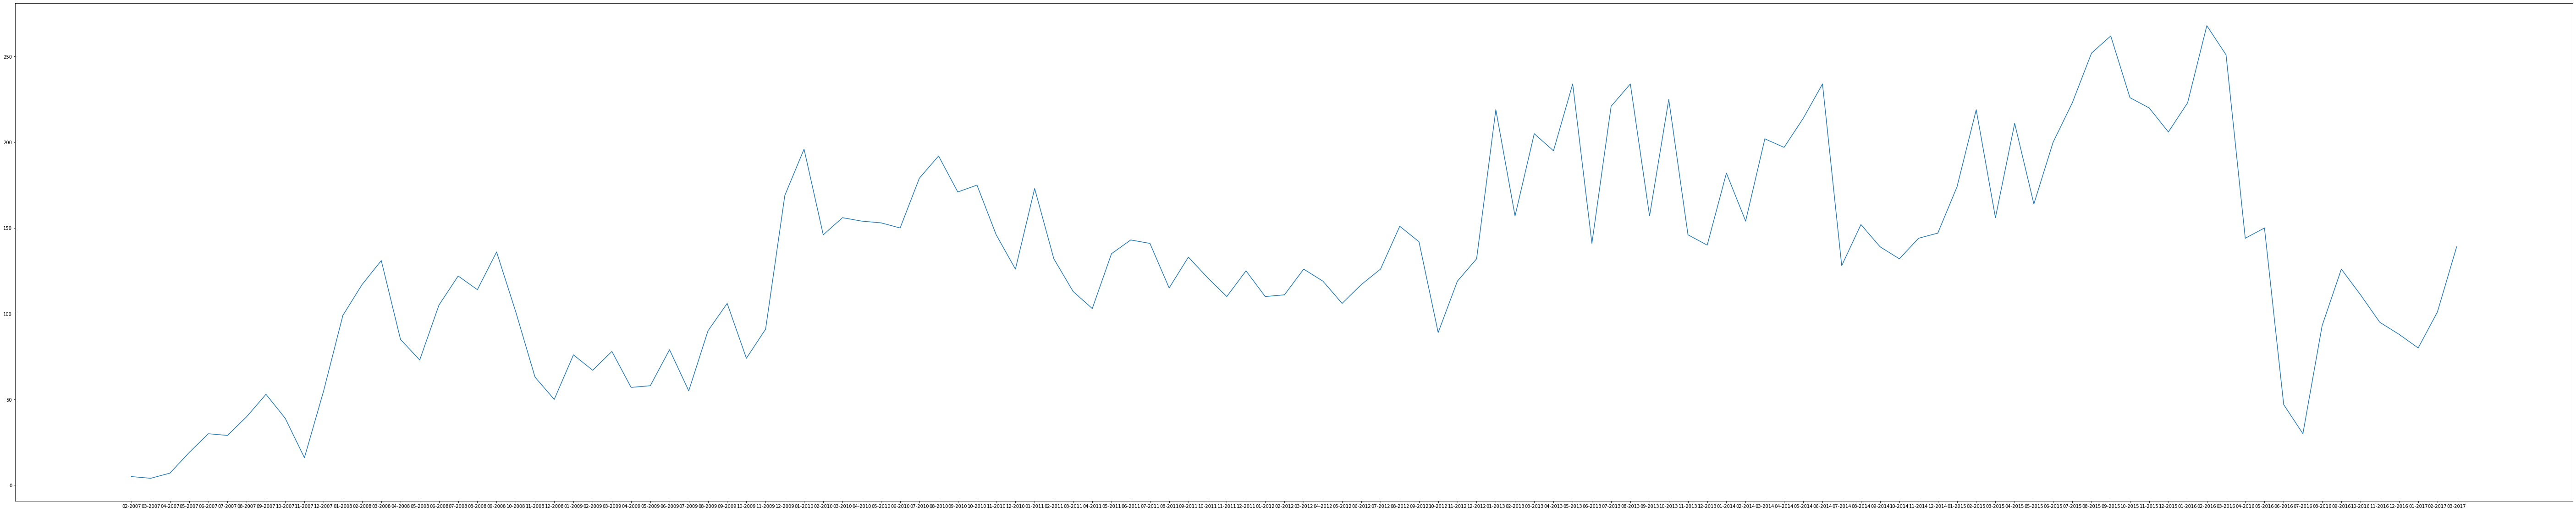

In [83]:
plt.figure(figsize=(100,20))
plt.plot(pandasDF['date'], pandasDF['numOfComments'])
plt.show()

# Analyze user *G_Morgan*

In [50]:
user = 'G_Morgan'

## Where is he/she from?

In [51]:
authorCountries.select('countries').filter(authorCountries.author == user).show()

+---------+
|countries|
+---------+
|[ireland]|
+---------+



## User sentiment

In [52]:
G_MorganSubredditSentimentDF = (G_MorganComment
                              .groupBy('author', 'subreddit')
                              .agg(
                                  calculatue_score_udf(func.collect_list('body')).alias('sentiment'), 
                                  func.count(func.lit(1)).alias('count')
                              )
                             )
G_MorganSubredditSentimentDF = G_MorganSubredditSentimentDF.filter(G_MorganSubredditSentimentDF['count']>=100)
G_MorganSubredditSentimentDF.cache()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

### Most positive subreddit

In [53]:
G_MorganSubredditSentimentDF.select('subreddit','sentiment').sort(func.desc('sentiment')).show()

+-------------+---------+
|    subreddit|sentiment|
+-------------+---------+
|       soccer| 244.7083|
|  programming| 122.0568|
|    reddevils|  88.4426|
|   rugbyunion|  56.5922|
|   ukpolitics|  42.6104|
|    starcraft|   27.699|
|        Games|  19.4366|
|   technology|  17.0578|
|       gaming|  14.8539|
|       europe|  12.8329|
|       Diablo|   9.8198|
|    AskReddit|   6.3025|
| paradoxplaza|   5.2344|
|  whowouldwin|   0.4686|
|     politics|  -1.7753|
|       skyrim|  -6.8758|
|   polandball|   -9.184|
|unitedkingdom| -37.3041|
|    worldnews| -37.9539|
+-------------+---------+



### Most negative subreddit

In [54]:
G_MorganSubredditSentimentDF.select('subreddit','sentiment').sort(func.asc('sentiment')).show()

+-------------+---------+
|    subreddit|sentiment|
+-------------+---------+
|    worldnews| -37.9539|
|unitedkingdom| -37.3041|
|   polandball|   -9.184|
|       skyrim|  -6.8758|
|     politics|  -1.7753|
|  whowouldwin|   0.4686|
| paradoxplaza|   5.2344|
|    AskReddit|   6.3025|
|       Diablo|   9.8198|
|       europe|  12.8329|
|       gaming|  14.8539|
|   technology|  17.0578|
|        Games|  19.4366|
|    starcraft|   27.699|
|   ukpolitics|  42.6104|
|   rugbyunion|  56.5922|
|    reddevils|  88.4426|
|  programming| 122.0568|
|       soccer| 244.7083|
+-------------+---------+



In [55]:
G_MorganSubredditSentimentDF.unpersist()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

## Analyze the active level of user from month to month by using the number of comments

In [56]:
G_MorganCommentsByTime = (G_MorganComment
                        .groupBy('month','year','author')
                        .agg(func.count(func.lit(1)).alias('numOfComments')))
# userCommentsByTime.cache()

In [57]:
G_MorganCommentsByTime = G_MorganCommentsByTime.sort(func.asc('year'), func.asc('month'))
G_MorganCommentsByTime.show()

+-----+----+--------+-------------+
|month|year|  author|numOfComments|
+-----+----+--------+-------------+
|   11|2007|G_Morgan|           11|
|   12|2007|G_Morgan|           17|
|    1|2008|G_Morgan|           22|
|    2|2008|G_Morgan|           15|
|    3|2008|G_Morgan|            7|
|    4|2008|G_Morgan|           17|
|    5|2008|G_Morgan|           20|
|    6|2008|G_Morgan|           18|
|    7|2008|G_Morgan|           16|
|    8|2008|G_Morgan|           15|
|    9|2008|G_Morgan|           24|
|   10|2008|G_Morgan|           40|
|   11|2008|G_Morgan|           32|
|   12|2008|G_Morgan|           32|
|    1|2009|G_Morgan|           39|
|    2|2009|G_Morgan|           33|
|    3|2009|G_Morgan|           38|
|    4|2009|G_Morgan|           57|
|    5|2009|G_Morgan|           79|
|    6|2009|G_Morgan|           64|
+-----+----+--------+-------------+
only showing top 20 rows



In [58]:
G_MorganCommentsByTime.coalesce(1).write.format('csv').save('hdfs://orion11:11001/A5/G_Morgan')

In [59]:
G_MorganComment.unpersist()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, mod_reports: array<string>, name: string, parent_id: string, removal_reason: string, replies: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>, year: int, month: int]

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

pandasDF = G_MorganCommentsByTime.toPandas()
pandasDF['date'] = pandasDF['month'].map(str)+ '-' +pandasDF['year'].map(str)
pandasDF['date'] = pd.to_datetime(pandasDF['date'], format='%m-%Y').dt.strftime('%m-%Y')
# fig, ax = plt.subplots()

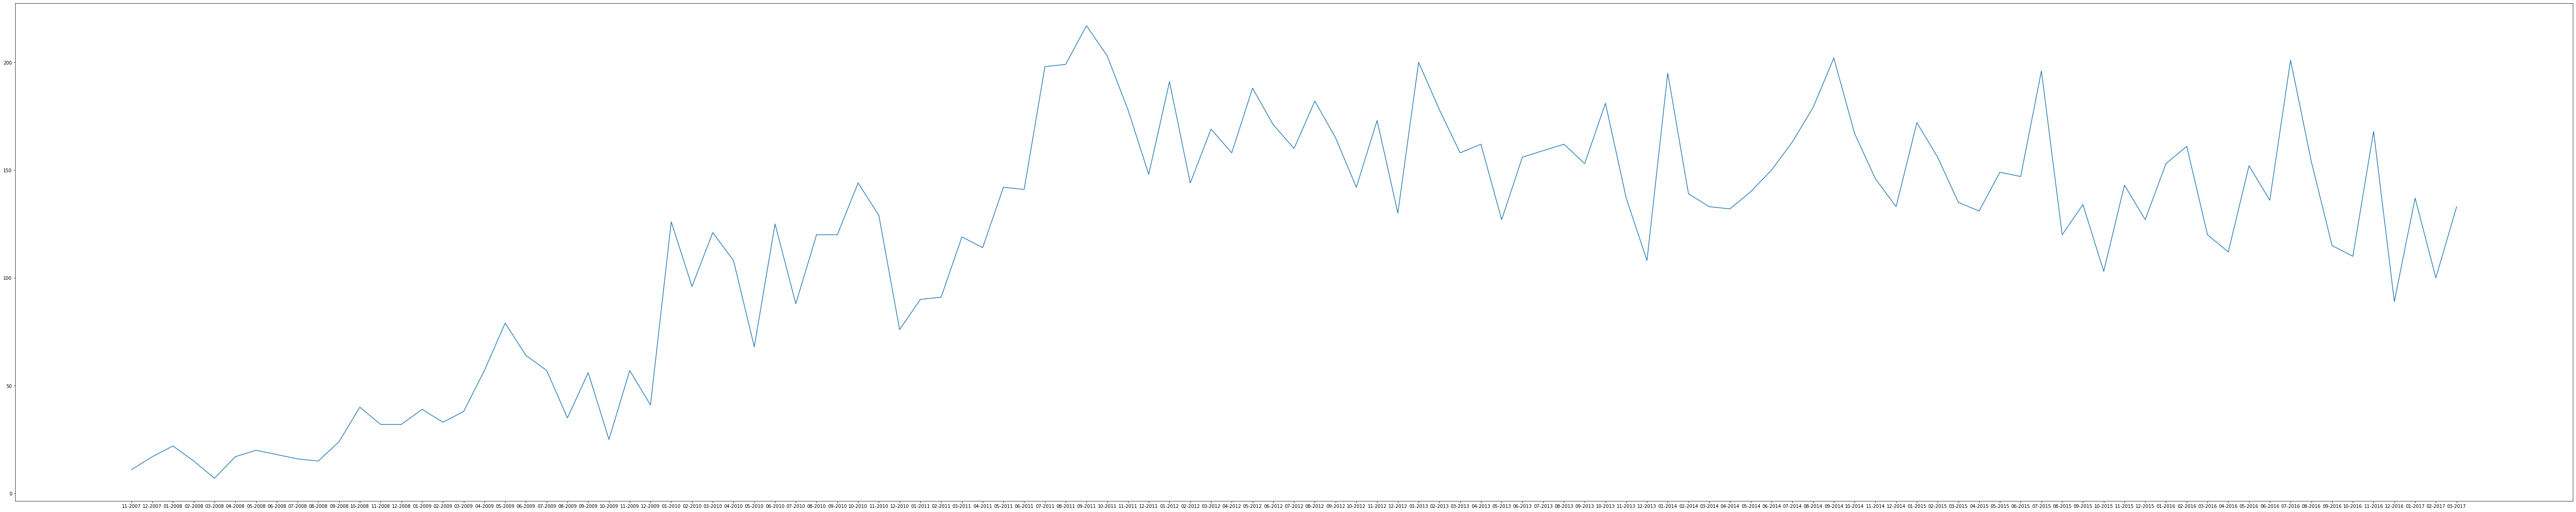

In [87]:
plt.figure(figsize=(100,20))
plt.plot(pandasDF['date'], pandasDF['numOfComments'])
plt.show()

# Analyze user *pixis-4950*

In [60]:
user = 'pixis-4950'

## Where is he/she from?

In [61]:
authorCountries.select('countries').filter(authorCountries.author == user).show()

+---------+
|countries|
+---------+
|[lebanon]|
+---------+



## User sentiment

In [62]:
pixis4950SubredditSentimentDF = (pixis4950Comment
                              .groupBy('author', 'subreddit')
                              .agg(
                                  calculatue_score_udf(func.collect_list('body')).alias('sentiment'), 
                                  func.count(func.lit(1)).alias('count')
                              )
                             )
pixis4950SubredditSentimentDF = pixis4950SubredditSentimentDF.filter(pixis4950SubredditSentimentDF['count']>=100)
pixis4950SubredditSentimentDF.cache()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

### Most positive subreddit

In [63]:
pixis4950SubredditSentimentDF.select('subreddit','sentiment').sort(func.desc('sentiment')).show()

+--------------------+---------+
|           subreddit|sentiment|
+--------------------+---------+
|  doublespeaksterile| 297.5334|
|   doublespeakgutter| 190.9985|
| doublespeaklockstep| 137.0193|
| doublespeakhysteric|  72.2128|
|doublespeakstockholm|  24.6981|
| doublespeakfwdrefwd|  23.6053|
|      doublespeakego|  15.8056|
| doublespeakdoctrine|  14.8113|
|   doublespeakclique|   9.0815|
|doublespeakblackcoat|    5.611|
|doublespeakwitchhunt|  -6.6075|
|doublespeakprostrate| -11.2033|
|           SRSHeroes| -52.4104|
|doublespeakprivilege|-221.5174|
+--------------------+---------+



### Most negative subreddit

In [64]:
pixis4950SubredditSentimentDF.select('subreddit','sentiment').sort(func.asc('sentiment')).show()

+--------------------+---------+
|           subreddit|sentiment|
+--------------------+---------+
|doublespeakprivilege|-221.5174|
|           SRSHeroes| -52.4104|
|doublespeakprostrate| -11.2033|
|doublespeakwitchhunt|  -6.6075|
|doublespeakblackcoat|    5.611|
|   doublespeakclique|   9.0815|
| doublespeakdoctrine|  14.8113|
|      doublespeakego|  15.8056|
| doublespeakfwdrefwd|  23.6053|
|doublespeakstockholm|  24.6981|
| doublespeakhysteric|  72.2128|
| doublespeaklockstep| 137.0193|
|   doublespeakgutter| 190.9985|
|  doublespeaksterile| 297.5334|
+--------------------+---------+



In [65]:
pixis4950SubredditSentimentDF.unpersist()

DataFrame[author: string, subreddit: string, sentiment: float, count: bigint]

## Analyze the active level of user from month to month by using the number of comments

In [66]:
pixis4950CommentsByTime = (pixis4950Comment
                        .groupBy('month','year','author')
                        .agg(func.count(func.lit(1)).alias('numOfComments')))
# userCommentsByTime.cache()

In [67]:
pixis4950CommentsByTime = pixis4950CommentsByTime.sort(func.asc('year'), func.asc('month'))
pixis4950CommentsByTime.show()

+-----+----+----------+-------------+
|month|year|    author|numOfComments|
+-----+----+----------+-------------+
|    5|2013|pixis-4950|          457|
|    6|2013|pixis-4950|         2436|
|    7|2013|pixis-4950|         4265|
|    8|2013|pixis-4950|         2915|
|    9|2013|pixis-4950|         2548|
|   10|2013|pixis-4950|         2095|
|   11|2013|pixis-4950|         1552|
|   12|2013|pixis-4950|          744|
+-----+----+----------+-------------+



In [68]:
pixis4950CommentsByTime.coalesce(1).write.format('csv').save('hdfs://orion11:11001/A5/pixis-4950')

In [69]:
pixis4950Comment.unpersist()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, mod_reports: array<string>, name: string, parent_id: string, removal_reason: string, replies: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>, year: int, month: int]

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

pandasDF = pixis4950CommentsByTime.toPandas()
pandasDF['date'] = pandasDF['month'].map(str)+ '-' +pandasDF['year'].map(str)
pandasDF['date'] = pd.to_datetime(pandasDF['date'], format='%m-%Y').dt.strftime('%m-%Y')
# fig, ax = plt.subplots()

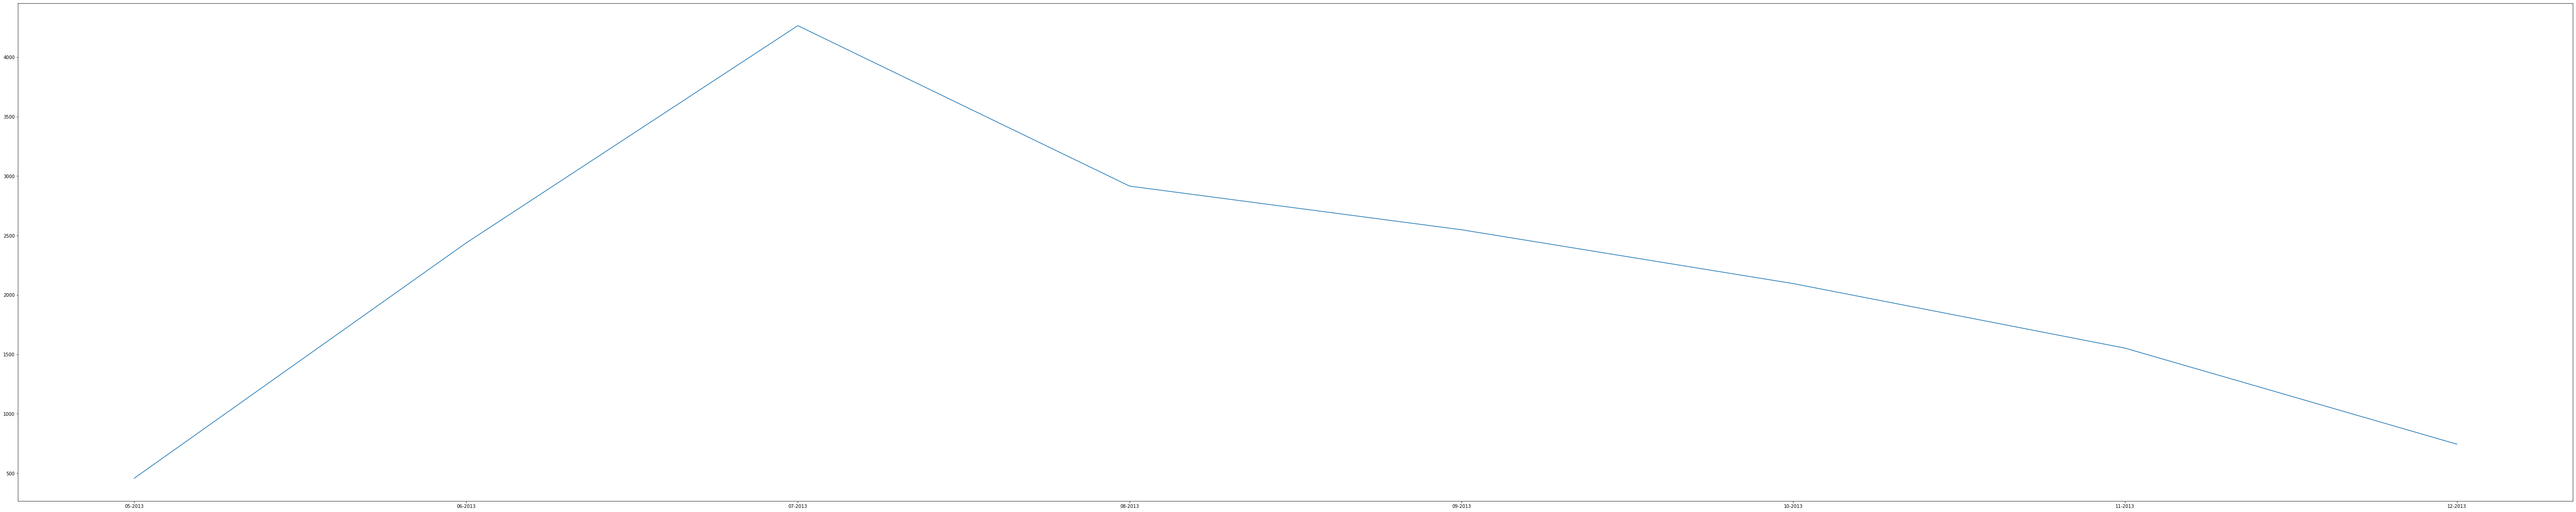

In [89]:
plt.figure(figsize=(100,20))
plt.plot(pandasDF['date'], pandasDF['numOfComments'])
plt.show()